# Prototipo de Sistema Inteligente - Enfermedad Renal Crónica

<p>A continuación se presenta el prototipo para el sistema inteligente que predice la probabilidad de padecer enfermedad renal crónica según las caracteristicas de los pacientes.</p>
<br/>
<details>
  <summary>Tabla de contenido</summary>
  <ul>
    <li>
      <a href="#Código-fuente">Código fuente</a>
      <ul>
        <li><a href="#Importar-librerias">Importar librerias</a></li>
        <li><a href="#Preparar-datos">Preparar datos</a></li>
        <li><a href="#Dividir-datos">Dividir datos</a></li>
        <li><a href="#Entrenar-modelo">Entrenar modelo</a></li>
        <li><a href="#Evaluar-modelo">Evaluar modelo</a></li>
        <li><a href="#Predecir">Predecir</a></li>  
      </ul>
    </li>
    <li><a href="#Autor">Autor</a></li>
    <li><a href="#Referencias">Referencias</a></li>
  </ul>
</details>



## Código fuente
### Importar librerias

Para procesamiento de datos

se importan las librerias pandas, sklearn y la coleccion de funciones de matplotlib.

In [1]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Modelo

RandomForestClassifier es un modelo clasificador de bosque aleatorio. Un bosque aleatorio es un metaestimador que se ajusta a una serie de clasificadores de árboles de decisión en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste.

In [2]:
from sklearn.ensemble import RandomForestClassifier

Para evaluación del modelo

Se verifican diferentes errores en las matrices de confusion y error medio absoluto 

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error

### Importar datos

Se agrega la colección de datos tabulados - dataset y se especifica el archivo CSV que queremos leer.

In [4]:
dataset = pd.read_csv('./input.csv')
datos = pd.DataFrame(dataset) # DataFrame alinea los datos de forma tabular en filas y columnas.

Se muestran 5 registros aleatorios de los datos cargados

In [5]:
datos.sample(5)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
187,187,3.0,NaN,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,34,12300,NaN,no,no,no,good,no,no,ckd
181,181,45.0,70.0,1.025,2.0,0.0,normal,abnormal,present,notpresent,...,30,19100,3.7,no,no,no,good,no,no,ckd
86,86,56.0,80.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,NaN,NaN,NaN,no,yes,no,good,no,no,ckd
116,116,NaN,70.0,1.015,4.0,0.0,abnormal,normal,notpresent,notpresent,...,NaN,NaN,NaN,no,no,no,good,yes,no,ckd
79,79,56.0,80.0,1.010,1.0,0.0,NaN,normal,notpresent,notpresent,...,40,11800,5.0,yes,yes,no,poor,yes,no,ckd


### Preparar datos

Se elimina la columna *id*, dado que no aporta al entrenamiento del modelo.

In [6]:
datos.drop('id', axis = 1, inplace = True)

Se renombran las columnas para facilitar la comprensión, 

las variables corresponde a:
-	Edad = age
-	Presion = blood_pressure
-	Gravedad especifica = specific_gravity
-	Alnbumina = albúmina
-	Azucar = sugar
-	Globulos Rojos = red_blood_cells
-	Pus Celular = pus_cell
-	Grupos de células de pus = pus_cell_clumps
-	Bacteria = bacteria
-	Glucosa en sagre aleatoria = blood_glucose_random
-	Urea en Sangre = blood_urea
-	Creatinina Serica = serum_creatinine
-	Sodio = sodium
-	Potasio = potassium
-	Hemoglobina = haemoglobin
-	Volumen de células empaquetadas = packed_cell_volume
-	Conteo de células blancas = white_blood_cell_count
-	Recuento de glóbulos rojos = red_blood_cell_count
-	Hipertensión = hypertensión
-	Diabetes mellitus = diabetes_mellitus
-	Enfermedad de la arteria coronaria = coronary_artery_disease
-	Apetito = appetite
-	Edema de los pies = peda_edema
-	Anemia = aanemia
-	Clase = class

In [7]:
datos.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'aanemia', 'class']

Se convierten columnas seleccionadas a tipo numérico

In [8]:
datos['packed_cell_volume'] = pd.to_numeric(datos['packed_cell_volume'], errors='coerce')
datos['white_blood_cell_count'] = pd.to_numeric(datos['white_blood_cell_count'], errors='coerce')
datos['red_blood_cell_count'] = pd.to_numeric(datos['red_blood_cell_count'], errors='coerce')

Se extraen columnas de categoría y columnas numéricas

In [9]:
columnas_categoria = [col for col in datos.columns if datos[col].dtype == 'object']
columnas_numericas = [col for col in datos.columns if datos[col].dtype != 'object']

Se reemplazan valores incorrectos

In [10]:
datos['diabetes_mellitus'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)
datos['coronary_artery_disease'] = datos['coronary_artery_disease'].replace(to_replace = '\tno', value='no')
datos['class'] = datos['class'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})

Se reemplaza **ckd** con 1 y **not ckd** con 0, estos serán utilizados como clasificación.

ckd representa en 1 que tiene la enfermedad renal cronico y 0 no la tiene.

In [11]:
datos['class'] = datos['class'].map({'ckd': 1, 'not ckd': 0})

Se convierte columna **class** en numérica.

In [12]:
datos['class'] = pd.to_numeric(datos['class'], errors='coerce')

Se reemplazan valores nulos para poder codificar características.
Se usan dos métodos
1. muestreo aleatorio para cuando los valores nulos tienen una alta frecuencia

In [13]:
def reemplazar_nulo_con_aleatorio(caracteristica):
    valor_aleatorio = datos[caracteristica].dropna().sample(datos[caracteristica].isna().sum())
    valor_aleatorio.index = datos[datos[caracteristica].isnull()].index
    datos.loc[datos[caracteristica].isnull(), caracteristica] = valor_aleatorio

2. Muestreo media/moda para valores nulos con poca frecuencia

In [14]:
def reemplazar_nulo_con_moda(caracteristica):
    moda = datos[caracteristica].mode()[0]
    datos[caracteristica] = datos[caracteristica].fillna(moda)

Se reemplazan valores nulos en las columnas numéricas con valores aleatorios

In [15]:
for columna in columnas_numericas:
    reemplazar_nulo_con_aleatorio(columna)

Se reemplazan valores nulos en las columnas **red_blood_cells** y **pus_cell** con valores aleatorios

In [16]:
reemplazar_nulo_con_aleatorio('red_blood_cells')
reemplazar_nulo_con_aleatorio('pus_cell')

Se reemplazan nulos por moda en las demás columnas de categoría

In [17]:
for columna in columnas_categoria:
    reemplazar_nulo_con_moda(columna)

Codificar características

In [18]:
codificadorCaracteristica = LabelEncoder()

for columna in columnas_categoria:
    datos[columna] = codificadorCaracteristica.fit_transform(datos[columna]) #fit_transform () es ajustar los datos primero y luego estandarizarlos.


datos.sample(5)

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
43,35.0,80.0,1.010,1.0,0.0,0,0,0,0,79.0,...,24.0,7900.0,3.1,0,1,0,0,0,0,1
220,36.0,80.0,1.010,0.0,0.0,1,1,0,0,103.0,...,36.0,8800.0,5.3,0,0,0,0,0,0,1
115,47.0,80.0,1.010,0.0,0.0,1,0,0,0,102.0,...,44.0,5600.0,4.3,0,0,0,0,0,1,1
98,50.0,140.0,1.015,2.0,5.0,1,1,0,0,101.0,...,18.0,5800.0,2.3,1,1,0,1,0,1,1
341,63.0,70.0,1.025,0.0,0.0,1,1,0,0,130.0,...,41.0,7300.0,4.7,0,0,0,0,0,0,0


### Dividir datos

Se elimina la clasificación de los datos para definir las características

In [19]:
caracteristicas = datos.drop("class", axis = 1 )

Se extrae la clasificación de los datos

In [20]:
clasificacion = datos['class']

Se dividen las caracteristicas y clasificación para el entrenamiento y la evaluación del modelo

In [21]:
caracteristicas_entrenamiento, caracteristicas_evaluacion, clasificacion_entrenamiento, clasificacion_evaluacion = train_test_split(caracteristicas, clasificacion, test_size= 0.2, random_state = 42)

### Entrenar modelo

Se entrena el modelo utilizando el clasificador de bosques aleatorios 

In [22]:
modelo = RandomForestClassifier()
modelo.fit(caracteristicas_entrenamiento, clasificacion_entrenamiento)

RandomForestClassifier()

### Evaluar modelo

Se realiza predicción utilizando el modelo sobre las características reservadas para la evaluación

In [23]:
clasificacion_prediccion = modelo.predict(caracteristicas_evaluacion)

Se calcula el error medio absoluto

In [24]:
mean_absolute_error(clasificacion_evaluacion, clasificacion_prediccion)

0.025

Se genera la matriz de Confusión

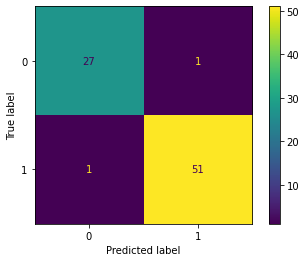

In [25]:
#  Matriz de confusión
matrizDeConfusion = confusion_matrix(clasificacion_evaluacion, clasificacion_prediccion)
displayConfusionMatrix = ConfusionMatrixDisplay(confusion_matrix = matrizDeConfusion, display_labels = modelo.classes_)
displayConfusionMatrix.plot()
plt.show()

### Predecir

Se selecciona un registro para predecir la probabilidad de padecer enfermedad renal crónica

In [26]:
ejemplo = caracteristicas.sample()
ejemplo

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia
64,55.0,80.0,1.01,0.0,0.0,1,1,0,0,146.0,...,9.8,41.0,11400.0,3.0,0,0,0,0,0,0


Se predice la probabilidad de padecer enfermedad renal crónica, para ello tomamos del resultado la primera posición por tratarse de una sola predicción o la predicción para un solo elemento. Obtenemos la probabilidad de la clasificación 1, teniendo en cuenta que las clasificación **ckd** es 1 y **not ckd** es 0.

In [27]:
probabilidad = modelo.predict_proba(ejemplo)
"{0:.0%}".format(probabilidad[0][1])

'100%'

### Solicitar Datos

Se solicitan la informacion del paciente para determinar la probabilidad de sufrir o no una enfermedad renal

In [28]:
name = input('Escriba su nombre completo: ')
test = input('Se ha realizado examenes de sangre recientes?: ')

if test == 'no':
    print('Por favor realizarse examenes de sangre e ingresarlos a la pagina.')
else:
    registro = int(input('Escriba el numero de registro de los examenes medicos: '))
    caracteristica = caracteristicas.loc[[registro-1]]
    display(HTML(caracteristica.to_html()))
    prediccionProbabilidad = modelo.predict_proba(caracteristica)[0][1]
    if prediccionProbabilidad > 0.5 :
        print("Usted podría padecer enfermedad renal con una probabilidad del {0:.0%}".format(prediccionProbabilidad))
    else:
        print("usted no tiene una enfermedad renal")

Escriba su nombre completo: paola
Se ha realizado examenes de sangre recientes?: si
Escriba el numero de registro de los examenes medicos: 64


,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia
63,46.0,70.0,1.015,1.0,0.0,0,1,0,0,150.0,111.0,6.1,131.0,3.7,7.5,27.0,6200.0,5.3,0,0,0,0,0,1


Usted podría padecer enfermedad renal con una probabilidad del 100%


## Autores
- Heidi Liliana Alvarado Sarmiento Código: 1.094.930.398
- Alexandra Paola Rivera Zuluaga Código: 1.053.791.795
- Jonatan Mayorga Villanueva Código: 86.085.356
- Wilmer Fidel Restrepo Orrego Codigo: 1.088.300.954

## Referencias

1. https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease
2. https://www.kaggle.com/code/iftekharifat/chronic-kidney-disease-prediction
3. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
4. https://es.wikipedia.org/wiki/Error_absoluto_medio
5. https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n